**Import Library & Dataset**

In [23]:
import pandas as pd
import numpy as np
import seaborn as sb
import plotly.express as px
import matplotlib.pyplot as plt
import re
import os
import nltk
from wordcloud import WordCloud,STOPWORDS
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
import warnings
warnings.filterwarnings('ignore')

In [25]:
# Reading the data
ens_learn = pd.read_csv('/content/traveloka2000.csv')
ens_learn_copy = ens_learn
# Checking first 10 rows of data
ens_learn.head(10)

,content,score
0,Penerbangan saya secara keseluruhan menggunaka...,5
1,Kesel bgt ih ! ngadain promo tapi pas di check...,1
2,saya download aplikasi ini cuma untuk ng bully...,1
3,Saya mau cancel orderan traveloka eats lama ba...,2
4,Tolong kalau memang ada pembatalan dari pihak ...,1
5,"Luar biasa, sangat membantu dan terpercaya, la...",5
6,"enak, cepat , mudah, dan ga ribet",5
7,"Traveloka mantap,recomended, lebih banyak lagi...",5
8,Pengalaman mengesankan saat refund. Fast respo...,5
9,Seminggu yang lalu saya daftar paylater tapi t...,5


# **1. Data Preprocessing**

**1.1 Labeling**

In [27]:
# labeling

ens_learn['label'] = ens_learn['score'].map({1:0, 2:0, 3:2, 4:1, 5:1})
ens_learn['category'] = ens_learn['score'].map({1:'negative', 2:'negative', 3:'neutral', 4:'positive', 5:'positive'})
ens_learn.head()

,content,score,label,category
0,Penerbangan saya secara keseluruhan menggunaka...,5,1,positive
1,Kesel bgt ih ! ngadain promo tapi pas di check...,1,0,negative
2,saya download aplikasi ini cuma untuk ng bully...,1,0,negative
3,Saya mau cancel orderan traveloka eats lama ba...,2,0,negative
4,Tolong kalau memang ada pembatalan dari pihak ...,1,0,negative


**1.2 Cleaning (case folding)**

In [28]:
# case folding

def clean_text(text):
  return re.sub('[^a-zA-Z]', ' ', text).lower()
ens_learn['cleaned_text'] = ens_learn['content'].apply(lambda x: clean_text(x))
ens_learn.head()

,content,score,label,category,cleaned_text
0,Penerbangan saya secara keseluruhan menggunaka...,5,1,positive,penerbangan saya secara keseluruhan menggunaka...
1,Kesel bgt ih ! ngadain promo tapi pas di check...,1,0,negative,kesel bgt ih ngadain promo tapi pas di check...
2,saya download aplikasi ini cuma untuk ng bully...,1,0,negative,saya download aplikasi ini cuma untuk ng bully...
3,Saya mau cancel orderan traveloka eats lama ba...,2,0,negative,saya mau cancel orderan traveloka eats lama ba...
4,Tolong kalau memang ada pembatalan dari pihak ...,1,0,negative,tolong kalau memang ada pembatalan dari pihak ...


**1.3 Filtering**

In [29]:
nltk.download('stopwords')
from nltk.corpus import stopwords

all_stopwords = stopwords.words('indonesian')
all_stopwords.remove('tidak')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [30]:
# Removing the URl

def rem_url(cleaned_text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',cleaned_text)

# Removing the stepwords 'indonesian'

def rem_stopwords(cleaned_text):
    cleaned_text = ' '.join([word for word in cleaned_text.split() if word not in (stopwords.words('indonesian'))])
    return cleaned_text

# Removing the html

def rem_html(cleaned_text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',cleaned_text)

def remove_at_mentions(cleaned_text):
    return re.sub(r'@\w+', '', cleaned_text)


# Removing emojis by codes

def rem_emoji(cleaned_text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"
                           u"\U0001F300-\U0001F5FF"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', cleaned_text)

# Fixing the cleaned_text

def fixing(cleaned_text):
    cleaned_text = re.sub(r"jembut", " buruk", cleaned_text)
    return cleaned_text

# Seperate alphabets

def sep_alphabets(cleaned_text):
    words = cleaned_text
    words = re.findall(r"[^\W\d_]+|\d+", words)
    return " ".join(words)


def review_to_words(review):
    letters_only = re.sub("[^a-zA-Z]", " ",review)
    words = letters_only.lower().split()
    stops = set(stopwords.words("indonesian"))
    meaningful_words = [w for w in words if not w in stops]
    return( " ".join( meaningful_words ))

ens_learn['filtered_text'] = ens_learn['cleaned_text']

ens_learn['filtered_text'] = ens_learn['filtered_text'].astype(str).apply(remove_at_mentions)
ens_learn['filtered_text'] = ens_learn['filtered_text'].apply(lambda x : rem_url(x))
ens_learn['filtered_text'] = ens_learn['filtered_text'].apply(lambda x : rem_stopwords(x))
ens_learn['filtered_text'] = ens_learn['filtered_text'].apply(lambda x : rem_html(x))
ens_learn['filtered_text'] = ens_learn['filtered_text'].apply(lambda x : rem_emoji(x))
ens_learn['filtered_text'] = ens_learn['filtered_text'].apply(lambda x : sep_alphabets(x))
ens_learn['filtered_text'] = ens_learn['filtered_text'].apply(lambda x : review_to_words(x))
ens_learn['filtered_text'] = ens_learn['filtered_text'].astype(str).replace("jembut", "buruk", regex=True)


# result

ens_learn['filtered_text']

0       penerbangan traveloka daftar pmbelian tiket pe...
1       kesel bgt ih ngadain promo pas checkout sistem...
2       download aplikasi ng bully aplikasi tiket depo...
3       cancel orderan traveloka eats banget jam disur...
4       tolong pembatalan maskapai konfirmasi pengajua...
                              ...                        
1995    bintang berhubung check in online ga menghubun...
1996    kecewa pembayaran paylater jatuh tempo bayar t...
1997    bikin paylatter susah bgt ud fotoin ktp nya ud...
1998              makasih traveloka konsisten kinerja nya
1999    bagus aplikasinya paylater gak prnh acc ngapai...
Name: filtered_text, Length: 2000, dtype: object

In [31]:
filtered_text = stopwords.words('indonesian')
ens_learn['filtered_text'] = ens_learn['filtered_text']
ens_learn.head()

,content,score,label,category,cleaned_text,filtered_text
0,Penerbangan saya secara keseluruhan menggunaka...,5,1,positive,penerbangan saya secara keseluruhan menggunaka...,penerbangan traveloka daftar pmbelian tiket pe...
1,Kesel bgt ih ! ngadain promo tapi pas di check...,1,0,negative,kesel bgt ih ngadain promo tapi pas di check...,kesel bgt ih ngadain promo pas checkout sistem...
2,saya download aplikasi ini cuma untuk ng bully...,1,0,negative,saya download aplikasi ini cuma untuk ng bully...,download aplikasi ng bully aplikasi tiket depo...
3,Saya mau cancel orderan traveloka eats lama ba...,2,0,negative,saya mau cancel orderan traveloka eats lama ba...,cancel orderan traveloka eats banget jam disur...
4,Tolong kalau memang ada pembatalan dari pihak ...,1,0,negative,tolong kalau memang ada pembatalan dari pihak ...,tolong pembatalan maskapai konfirmasi pengajua...


**1.4 Tokenizing**

In [32]:
# tokenizing

def tokenize_text(text):
  tokenized_text = text.split()
  return tokenized_text
ens_learn['tokens'] = ens_learn['filtered_text'].apply(lambda x: tokenize_text(x))
ens_learn.head()

,content,score,label,category,cleaned_text,filtered_text,tokens
0,Penerbangan saya secara keseluruhan menggunaka...,5,1,positive,penerbangan saya secara keseluruhan menggunaka...,penerbangan traveloka daftar pmbelian tiket pe...,"[penerbangan, traveloka, daftar, pmbelian, tik..."
1,Kesel bgt ih ! ngadain promo tapi pas di check...,1,0,negative,kesel bgt ih ngadain promo tapi pas di check...,kesel bgt ih ngadain promo pas checkout sistem...,"[kesel, bgt, ih, ngadain, promo, pas, checkout..."
2,saya download aplikasi ini cuma untuk ng bully...,1,0,negative,saya download aplikasi ini cuma untuk ng bully...,download aplikasi ng bully aplikasi tiket depo...,"[download, aplikasi, ng, bully, aplikasi, tike..."
3,Saya mau cancel orderan traveloka eats lama ba...,2,0,negative,saya mau cancel orderan traveloka eats lama ba...,cancel orderan traveloka eats banget jam disur...,"[cancel, orderan, traveloka, eats, banget, jam..."
4,Tolong kalau memang ada pembatalan dari pihak ...,1,0,negative,tolong kalau memang ada pembatalan dari pihak ...,tolong pembatalan maskapai konfirmasi pengajua...,"[tolong, pembatalan, maskapai, konfirmasi, pen..."


**1.5 Steamming**

In [33]:
!pip install Sastrawi
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# Inisialisasi Stemmer Bahasa Indonesia
stemmer = StemmerFactory().create_stemmer()

# Fungsi Lemmatisasi (Stemming) untuk Bahasa Indonesia
def stem_text(token_list):
    return " ".join([stemmer.stem(token) for token in token_list])

# Menerapkan Stemming pada DataFrame
ens_learn['stemmed_review'] = ens_learn['tokens'].apply(lambda x: stem_text(x))
ens_learn.head()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 4.4 MB/s eta 0:00:00


,content,score,label,category,cleaned_text,filtered_text,tokens,stemmed_review
0,Penerbangan saya secara keseluruhan menggunaka...,5,1,positive,penerbangan saya secara keseluruhan menggunaka...,penerbangan traveloka daftar pmbelian tiket pe...,"[penerbangan, traveloka, daftar, pmbelian, tik...",terbang traveloka daftar pmbelian tiket pesawa...
1,Kesel bgt ih ! ngadain promo tapi pas di check...,1,0,negative,kesel bgt ih ngadain promo tapi pas di check...,kesel bgt ih ngadain promo pas checkout sistem...,"[kesel, bgt, ih, ngadain, promo, pas, checkout...",kesel bgt ih ngadain promo pas checkout sistem...
2,saya download aplikasi ini cuma untuk ng bully...,1,0,negative,saya download aplikasi ini cuma untuk ng bully...,download aplikasi ng bully aplikasi tiket depo...,"[download, aplikasi, ng, bully, aplikasi, tike...",download aplikasi ng bully aplikasi tiket depo...
3,Saya mau cancel orderan traveloka eats lama ba...,2,0,negative,saya mau cancel orderan traveloka eats lama ba...,cancel orderan traveloka eats banget jam disur...,"[cancel, orderan, traveloka, eats, banget, jam...",cancel order traveloka eats banget jam suruh n...
4,Tolong kalau memang ada pembatalan dari pihak ...,1,0,negative,tolong kalau memang ada pembatalan dari pihak ...,tolong pembatalan maskapai konfirmasi pengajua...,"[tolong, pembatalan, maskapai, konfirmasi, pen...",tolong batal maskapai konfirmasi aju reschedul...


In [34]:
from IPython.display import display
display(ens_learn)

,content,score,label,category,cleaned_text,filtered_text,tokens,stemmed_review
0,Penerbangan saya secara keseluruhan menggunaka...,5,1,positive,penerbangan saya secara keseluruhan menggunaka...,penerbangan traveloka daftar pmbelian tiket pe...,"[penerbangan, traveloka, daftar, pmbelian, tik...",terbang traveloka daftar pmbelian tiket pesawa...
1,Kesel bgt ih ! ngadain promo tapi pas di check...,1,0,negative,kesel bgt ih ngadain promo tapi pas di check...,kesel bgt ih ngadain promo pas checkout sistem...,"[kesel, bgt, ih, ngadain, promo, pas, checkout...",kesel bgt ih ngadain promo pas checkout sistem...
2,saya download aplikasi ini cuma untuk ng bully...,1,0,negative,saya download aplikasi ini cuma untuk ng bully...,download aplikasi ng bully aplikasi tiket depo...,"[download, aplikasi, ng, bully, aplikasi, tike...",download aplikasi ng bully aplikasi tiket depo...
3,Saya mau cancel orderan traveloka eats lama ba...,2,0,negative,saya mau cancel orderan traveloka eats lama ba...,cancel orderan traveloka eats banget jam disur...,"[cancel, orderan, traveloka, eats, banget, jam...",cancel order traveloka eats banget jam suruh n...
4,Tolong kalau memang ada pembatalan dari pihak ...,1,0,negative,tolong kalau memang ada pembatalan dari pihak ...,tolong pembatalan maskapai konfirmasi pengajua...,"[tolong, pembatalan, maskapai, konfirmasi, pen...",tolong batal maskapai konfirmasi aju reschedul...
...,...,...,...,...,...,...,...,...
1995,"Tadinya saya beri bintang 5, berhubung saya ch...",1,0,negative,tadinya saya beri bintang berhubung saya ch...,bintang berhubung check in online ga menghubun...,"[bintang, berhubung, check, in, online, ga, me...",bintang hubung check in online ga hubung cs ar...
1996,Kecewa !! Selama ini pembayaran paylater tidak...,1,0,negative,kecewa selama ini pembayaran paylater tidak...,kecewa pembayaran paylater jatuh tempo bayar t...,"[kecewa, pembayaran, paylater, jatuh, tempo, b...",kecewa bayar paylater jatuh tempo bayar telat ...
1997,"Kok mau bikin paylatter,susah bgt, ud fotoin k...",2,0,negative,kok mau bikin paylatter susah bgt ud fotoin k...,bikin paylatter susah bgt ud fotoin ktp nya ud...,"[bikin, paylatter, susah, bgt, ud, fotoin, ktp...",bikin paylatter susah bgt ud fotoin ktp nya ud...
1998,makasih traveloka. sudah konsisten dengan kine...,5,1,positive,makasih traveloka sudah konsisten dengan kine...,makasih traveloka konsisten kinerja nya,"[makasih, traveloka, konsisten, kinerja, nya]",makasih traveloka konsisten kerja nya


In [35]:
display(ens_learn[['score', 'label', 'category', 'stemmed_review']])

,score,label,category,stemmed_review
0,5,1,positive,terbang traveloka daftar pmbelian tiket pesawa...
1,1,0,negative,kesel bgt ih ngadain promo pas checkout sistem...
2,1,0,negative,download aplikasi ng bully aplikasi tiket depo...
3,2,0,negative,cancel order traveloka eats banget jam suruh n...
4,1,0,negative,tolong batal maskapai konfirmasi aju reschedul...
...,...,...,...,...
1995,1,0,negative,bintang hubung check in online ga hubung cs ar...
1996,1,0,negative,kecewa bayar paylater jatuh tempo bayar telat ...
1997,2,0,negative,bikin paylatter susah bgt ud fotoin ktp nya ud...
1998,5,1,positive,makasih traveloka konsisten kerja nya


# **Hasil Dataset Preprocessing**

In [36]:
my_ens_learn = ens_learn[['score', 'label', 'category', 'stemmed_review']]

In [38]:
my_ens_learn.to_csv("preprocessingTraveloka.csv", index = False)

In [39]:
# Baca file CSV menjadi DataFrame
ens_learn = pd.read_csv('preprocessingTraveloka.csv')

# Tampilkan DataFrame sebelum penghapusan
print("DataFrame Sebelum Penghapusan:")
display(ens_learn)

DataFrame Sebelum Penghapusan:


,score,label,category,stemmed_review
0,5,1,positive,terbang traveloka daftar pmbelian tiket pesawa...
1,1,0,negative,kesel bgt ih ngadain promo pas checkout sistem...
2,1,0,negative,download aplikasi ng bully aplikasi tiket depo...
3,2,0,negative,cancel order traveloka eats banget jam suruh n...
4,1,0,negative,tolong batal maskapai konfirmasi aju reschedul...
...,...,...,...,...
1995,1,0,negative,bintang hubung check in online ga hubung cs ar...
1996,1,0,negative,kecewa bayar paylater jatuh tempo bayar telat ...
1997,2,0,negative,bikin paylatter susah bgt ud fotoin ktp nya ud...
1998,5,1,positive,makasih traveloka konsisten kerja nya


In [40]:
# Baca file CSV menjadi DataFrame
ens_learn = pd.read_csv('preprocessingTraveloka.csv')

# Hapus baris dengan nilai kosong
ens_learn_cleaned = ens_learn.dropna()

# Tampilkan DataFrame setelah penghapusan
print("\nDataFrame Setelah Penghapusan:")
display(ens_learn)

# Simpan DataFrame setelah penghapusan ke file CSV baru (opsional)
ens_learn_cleaned.to_csv('preprocessingTraveloka.csv', index=False)


DataFrame Setelah Penghapusan:


,score,label,category,stemmed_review
0,5,1,positive,terbang traveloka daftar pmbelian tiket pesawa...
1,1,0,negative,kesel bgt ih ngadain promo pas checkout sistem...
2,1,0,negative,download aplikasi ng bully aplikasi tiket depo...
3,2,0,negative,cancel order traveloka eats banget jam suruh n...
4,1,0,negative,tolong batal maskapai konfirmasi aju reschedul...
...,...,...,...,...
1995,1,0,negative,bintang hubung check in online ga hubung cs ar...
1996,1,0,negative,kecewa bayar paylater jatuh tempo bayar telat ...
1997,2,0,negative,bikin paylatter susah bgt ud fotoin ktp nya ud...
1998,5,1,positive,makasih traveloka konsisten kerja nya


In [41]:
#Checking number of null values

ens_learn.isna().sum()

score             0
label             0
category          0
stemmed_review    0
dtype: int64

# **2. EDA**

In [42]:
# Check the number of sentiments based on the rating
# shape of the dataset, and breakdown of the classes

print(f"Input data has {len(ens_learn)} rows and {len(ens_learn.columns)} columns")
print(f"rating 1 = {len(ens_learn[ens_learn['score']==1])} rows")
print(f"rating 2 = {len(ens_learn[ens_learn['score']==2])} rows")
print(f"rating 3 = {len(ens_learn[ens_learn['score']==3])} rows")
print(f"rating 4 = {len(ens_learn[ens_learn['score']==4])} rows")
print(f"rating 5 = {len(ens_learn[ens_learn['score']==5])} rows")

Input data has 2000 rows and 4 columns
rating 1 = 834 rows
rating 2 = 121 rows
rating 3 = 124 rows
rating 4 = 117 rows
rating 5 = 804 rows


Number of null in label: 0
Number of null in text: 0


<Axes: xlabel='score', ylabel='count'>

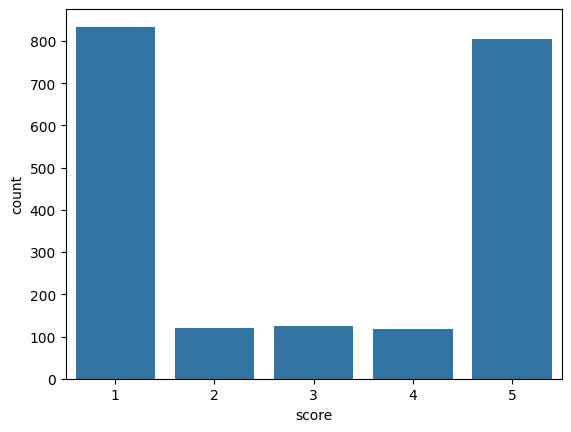

In [43]:
# Missing values in the dataset

print(f"Number of null in label: { ens_learn['score'].isnull().sum() }")
print(f"Number of null in text: { ens_learn['stemmed_review'].isnull().sum() }")
sb.countplot(x='score', data=ens_learn)

Number of null in label: 0
Number of null in text: 0


<Axes: xlabel='category', ylabel='count'>

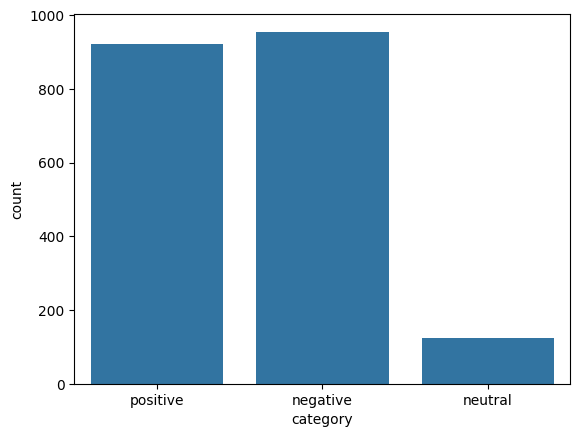

In [44]:
print(f"Number of null in label: { ens_learn['category'].isnull().sum() }")
print(f"Number of null in text: { ens_learn['stemmed_review'].isnull().sum() }")
sb.countplot(x='category', data=ens_learn)

**2.1 Category Percentage**

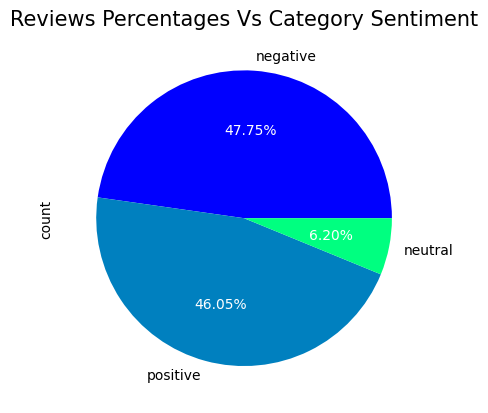

In [45]:
# Checking percentages from each category
plt.title("Reviews Percentages Vs Category Sentiment", fontsize=15)
ax = ens_learn.category.value_counts().plot(
    kind='pie', autopct='%1.2f%%', cmap="winter",
)

# Set label angka persentase menjadi warna putih
for text in ax.texts:
    # Jika teks adalah persentase (di dalam diagram), ubah warnanya menjadi putih
    if '%' in text.get_text():
        text.set_color('white')
    # Jika teks adalah label (di luar diagram), ubah warnanya menjadi hitam
    else:
        text.set_color('black')

plt.show()

**2.2 Wordcloud visualization**

In [46]:
# Separation of dataset based on rating value ('score')

ens_learn_positive = ens_learn[ (ens_learn['score']==4) | (ens_learn['score']==5)]
ens_learn_neutral = ens_learn[ (ens_learn['score']==3)]
ens_learn_negative = ens_learn[ (ens_learn['score']==1) | (ens_learn['score']==2)]

#convert to list
positive_list = ens_learn_positive['stemmed_review'].tolist()
neutral_list = ens_learn_neutral['stemmed_review'].tolist()
negative_list = ens_learn_negative['stemmed_review'].tolist()

filtered_positive = ("").join(str(positive_list)) #convert the list into a string of spam
filtered_positive = filtered_positive.lower()

filtered_neutral = ("").join(str(neutral_list)) #convert the list into a string of spam
filtered_neutral = filtered_neutral.lower()

filtered_negative = ("").join(str(negative_list)) #convert the list into a string of spam
filtered_negative = filtered_negative.lower()

In [47]:
# Menghitung total token pada masing-masing kategori
total_tokens_positive = len(filtered_positive.split())
total_tokens_neutral = len(filtered_neutral.split())
total_tokens_negative = len(filtered_negative.split())

# Menampilkan hasil
print("Total Tokens in Positive Category:", total_tokens_positive)
print("Total Tokens in Neutral Category:", total_tokens_neutral)
print("Total Tokens in Negative Category:", total_tokens_negative)


Total Tokens in Positive Category: 10704
Total Tokens in Neutral Category: 2163
Total Tokens in Negative Category: 20060


**2.2.1 Positive**

In [48]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

# Menerapkan TF-IDF pada teks positif
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(positive_list)

# Mendapatkan nama fitur (kata-kata)
feature_names = tfidf_vectorizer.get_feature_names_out()

# Mendapatkan bobot TF-IDF untuk setiap kata
tfidf_values = tfidf_matrix.sum(axis=0).A1

# Membuat DataFrame untuk menyimpan kata-kata dan bobot TF-IDF
tfidf_df = pd.DataFrame({'Word': feature_names, 'TF-IDF': tfidf_values})

# Mengurutkan DataFrame berdasarkan bobot TF-IDF secara descending
tfidf_df = tfidf_df.sort_values(by='TF-IDF', ascending=False)

# Menghitung persentase bobot TF-IDF
total_tfidf = tfidf_df['TF-IDF'].sum()
tfidf_df['Percentage'] = (tfidf_df['TF-IDF'] / total_tfidf) * 100

# Menampilkan hasil
print(tfidf_df)

           Word     TF-IDF  Percentage
1813  traveloka  66.008032    2.497485
1116      mudah  60.436731    2.286688
175       bantu  51.931212    1.964873
1757      tiket  40.681370    1.539223
334       cepat  39.422307    1.491585
...         ...        ...         ...
258        blow   0.117429    0.004443
264        bnyk   0.117429    0.004443
1005       mall   0.117429    0.004443
430    dijakbar   0.117429    0.004443
1497     saring   0.117429    0.004443

[1948 rows x 3 columns]


In [49]:
# Menentukan kata yang dicari
target_word = "mantap"

# Menghitung jumlah kemunculan kata "mantab" pada kategori positif
count_neutral = filtered_positive.count(target_word)

# Menampilkan hasil
print(f"Jumlah kata '{target_word}' pada kategori positif: {count_neutral}")


Jumlah kata 'mantap' pada kategori positif: 45


In [50]:
# Menentukan kata yang dicari
target_word = "mantap"

# Mengecek berapa banyak dokumen yang mengandung kata "mantap" pada kategori positif
documents_containing_word = ens_learn_positive['stemmed_review'].str.contains(target_word).sum()

# Menampilkan hasil
print(f"Jumlah dokumen pada kategori positif yang mengandung kata '{target_word}': {documents_containing_word}")

Jumlah dokumen pada kategori positif yang mengandung kata 'mantap': 44


In [51]:
# Menentukan kata yang dicari
target_word = "mantap"

# Mengambil dokumen yang mengandung kata "mantap" pada kategori positif
filtered_positive_with_word = ens_learn_positive[ens_learn_positive['stemmed_review'].str.contains(target_word)]

# Menggabungkan teks dari dokumen-dokumen tersebut
combined_text = (" ").join(filtered_positive_with_word['stemmed_review'].tolist()).lower()

# Menghitung total token pada dokumen-dokumen tersebut
total_tokens_combined = len(combined_text.split())

# Menampilkan hasil
print(f"Total token pada dokumen-dokumen kategori positif yang mengandung kata '{target_word}': {total_tokens_combined}")

Total token pada dokumen-dokumen kategori positif yang mengandung kata 'mantap': 386


In [52]:
# Menghitung total TF-IDF pada kategori positif
total_tfidf_neutral = tfidf_df['TF-IDF'].sum()

# Menampilkan total TF-IDF pada kategori positif
print("Total TF-IDF pada kategori positif:", total_tfidf)


Total TF-IDF pada kategori positif: 2642.9806050005673


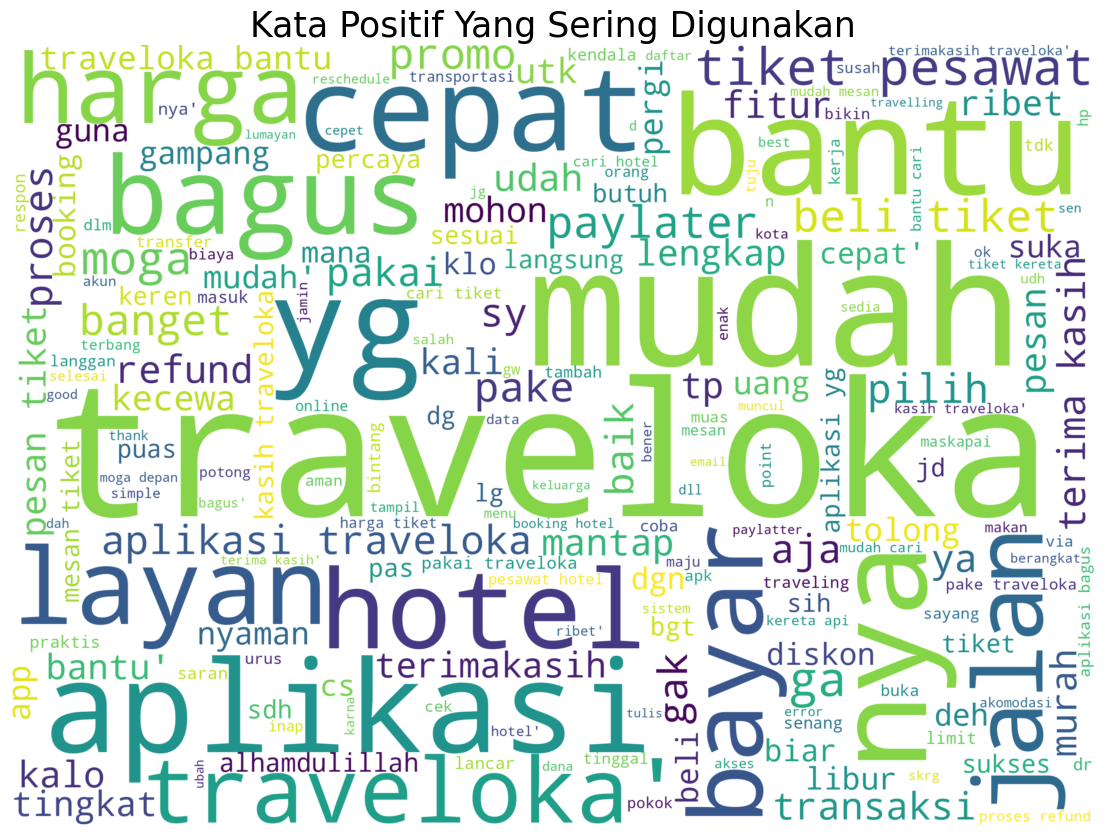

In [59]:
ens_learn_temp =ens_learn

ens_learn_temp['stemmed_review'].map(lambda x: re.sub('[,\.!?]', '', x))
ens_learn_temp['stemmed_review'].map(lambda x: x.lower())
pos_cloud=ens_learn_temp[ens_learn_temp['stemmed_review']=='positive_list']

word_cloud = WordCloud(stopwords=STOPWORDS,
                      background_color='White',
                      width=2500,
                      height=1800
                     ).generate(filtered_positive)
plt.figure(1,figsize=(14, 14))
plt.imshow(word_cloud,interpolation='bilinear')
plt.axis('off')
plt.title('Kata Positif Yang Sering Digunakan', fontsize=25)
plt.show()

**2.2.3 Negative**

In [55]:
# Menerapkan TF-IDF pada teks negatif
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(negative_list)

# Mendapatkan nama fitur (kata-kata)
feature_names = tfidf_vectorizer.get_feature_names_out()

# Mendapatkan bobot TF-IDF untuk setiap kata
tfidf_values = tfidf_matrix.sum(axis=0).A1

# Membuat DataFrame untuk menyimpan kata-kata dan bobot TF-IDF
tfidf_df = pd.DataFrame({'Word': feature_names, 'TF-IDF': tfidf_values})

# Mengurutkan DataFrame berdasarkan bobot TF-IDF secara descending
tfidf_df = tfidf_df.sort_values(by='TF-IDF', ascending=False)

# Menghitung persentase bobot TF-IDF
total_tfidf = tfidf_df['TF-IDF'].sum()
tfidf_df['Percentage'] = (tfidf_df['TF-IDF'] / total_tfidf) * 100

# Menampilkan hasil
print(tfidf_df)

           Word     TF-IDF  Percentage
2793  traveloka  48.724403    1.374066
142    aplikasi  37.548628    1.058901
2190     refund  35.572316    1.003167
2724      tiket  35.386454    0.997926
257       bayar  31.435780    0.886513
...         ...        ...         ...
2747      tnggu   0.116690    0.003291
669         dkt   0.116690    0.003291
445      byaran   0.116690    0.003291
1224      kesah   0.116690    0.003291
2505        sni   0.116690    0.003291

[2982 rows x 3 columns]


In [56]:
# Menentukan kata yang dicari
target_word = "gagal"

# Mengecek berapa banyak dokumen yang mengandung kata "login" pada kategori negatif
documents_containing_word = ens_learn_negative['stemmed_review'].str.contains(target_word).sum()

# Menampilkan hasil
print(f"Jumlah dokumen pada kategori negatif yang mengandung kata '{target_word}': {documents_containing_word}")

Jumlah dokumen pada kategori negatif yang mengandung kata 'gagal': 32


In [57]:
# Menghitung total TF-IDF pada kategori negatif
total_tfidf_neutral = tfidf_df['TF-IDF'].sum()

# Menampilkan total TF-IDF pada kategori netral
print("Total TF-IDF pada kategori negatif:", total_tfidf)


Total TF-IDF pada kategori negatif: 3546.001366217027


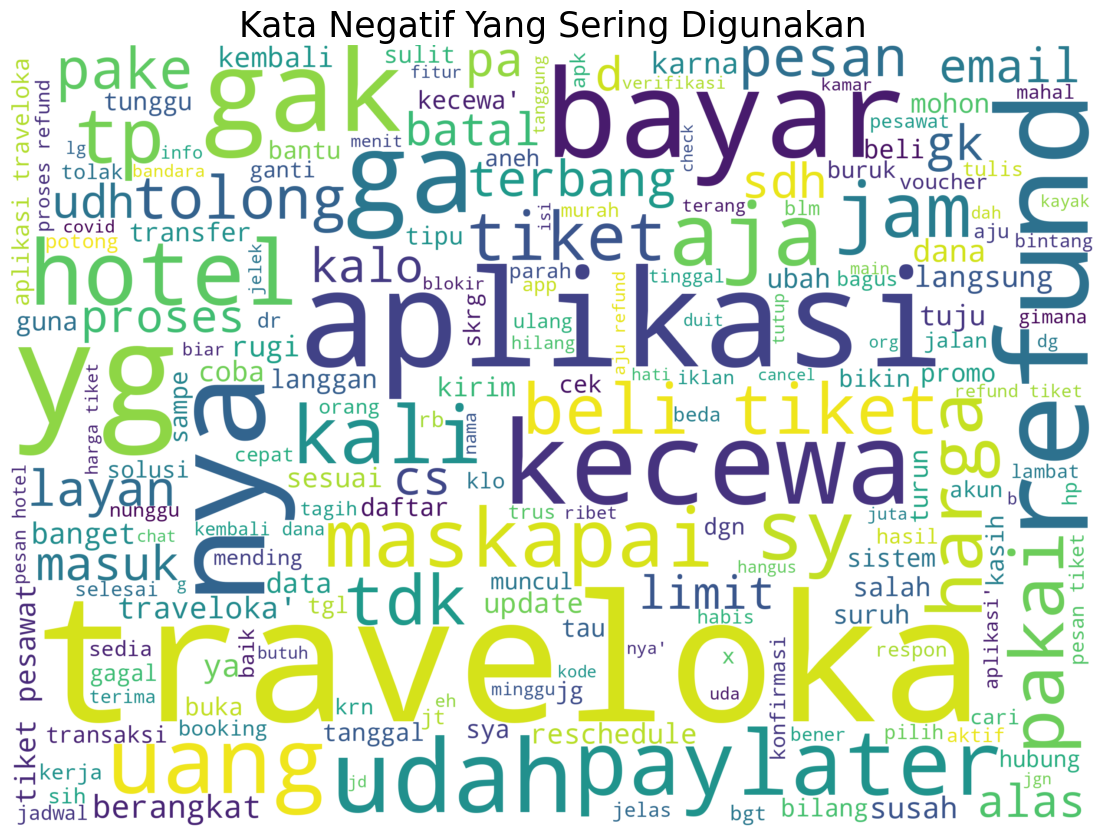

In [60]:
ens_learn_temp =ens_learn

ens_learn_temp['stemmed_review'].map(lambda x: re.sub('[,\.!?]', '', x))
ens_learn_temp['stemmed_review'].map(lambda x: x.lower())
neg_cloud=ens_learn_temp[ens_learn_temp['stemmed_review']=='negative']

word_cloud = WordCloud(stopwords=STOPWORDS,
                      background_color='White',
                      width=2500,
                      height=1800
                     ).generate(filtered_negative)
plt.figure(1,figsize=(14, 14))
plt.imshow(word_cloud,interpolation='bilinear')
plt.axis('off')
plt.title('Kata Negatif Yang Sering Digunakan', fontsize=25)
plt.show()

**2.2.2 Neutral**

In [61]:
# Menerapkan TF-IDF pada teks netral
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(neutral_list)

# Mendapatkan nama fitur (kata-kata)
feature_names = tfidf_vectorizer.get_feature_names_out()

# Mendapatkan bobot TF-IDF untuk setiap kata
tfidf_values = tfidf_matrix.sum(axis=0).A1

# Membuat DataFrame untuk menyimpan kata-kata dan bobot TF-IDF
tfidf_df = pd.DataFrame({'Word': feature_names, 'TF-IDF': tfidf_values})

# Mengurutkan DataFrame berdasarkan bobot TF-IDF secara descending
tfidf_df = tfidf_df.sort_values(by='TF-IDF', ascending=False)

# Menghitung persentase bobot TF-IDF
total_tfidf = tfidf_df['TF-IDF'].sum()
tfidf_df['Percentage'] = (tfidf_df['TF-IDF'] / total_tfidf) * 100

# Menampilkan hasil
print(tfidf_df)

          Word    TF-IDF  Percentage
779  traveloka  5.349823    1.251433
758      tiket  4.903756    1.147089
67       bayar  4.832000    1.130304
31    aplikasi  4.714646    1.102852
765     tolong  4.278165    1.000750
..         ...       ...         ...
78      bensin  0.109272    0.025561
718   supplier  0.109272    0.025561
185        dlm  0.109272    0.025561
97         bkn  0.109272    0.025561
517       nota  0.109272    0.025561

[835 rows x 3 columns]


In [62]:
# Menentukan kata yang dicari
target_word = "masuk"

# Mengecek berapa banyak dokumen yang mengandung kata "login" pada kategori negatif
documents_containing_word = ens_learn_neutral['stemmed_review'].str.contains(target_word).sum()

# Menampilkan hasil
print(f"Jumlah dokumen pada kategori negatif yang mengandung kata '{target_word}': {documents_containing_word}")

Jumlah dokumen pada kategori negatif yang mengandung kata 'masuk': 8


In [63]:
# Menghitung total TF-IDF pada kategori netral
total_tfidf_neutral = tfidf_df['TF-IDF'].sum()

# Menampilkan total TF-IDF pada kategori netral
print("Total TF-IDF pada kategori netral:", total_tfidf)


Total TF-IDF pada kategori netral: 427.49574559675426


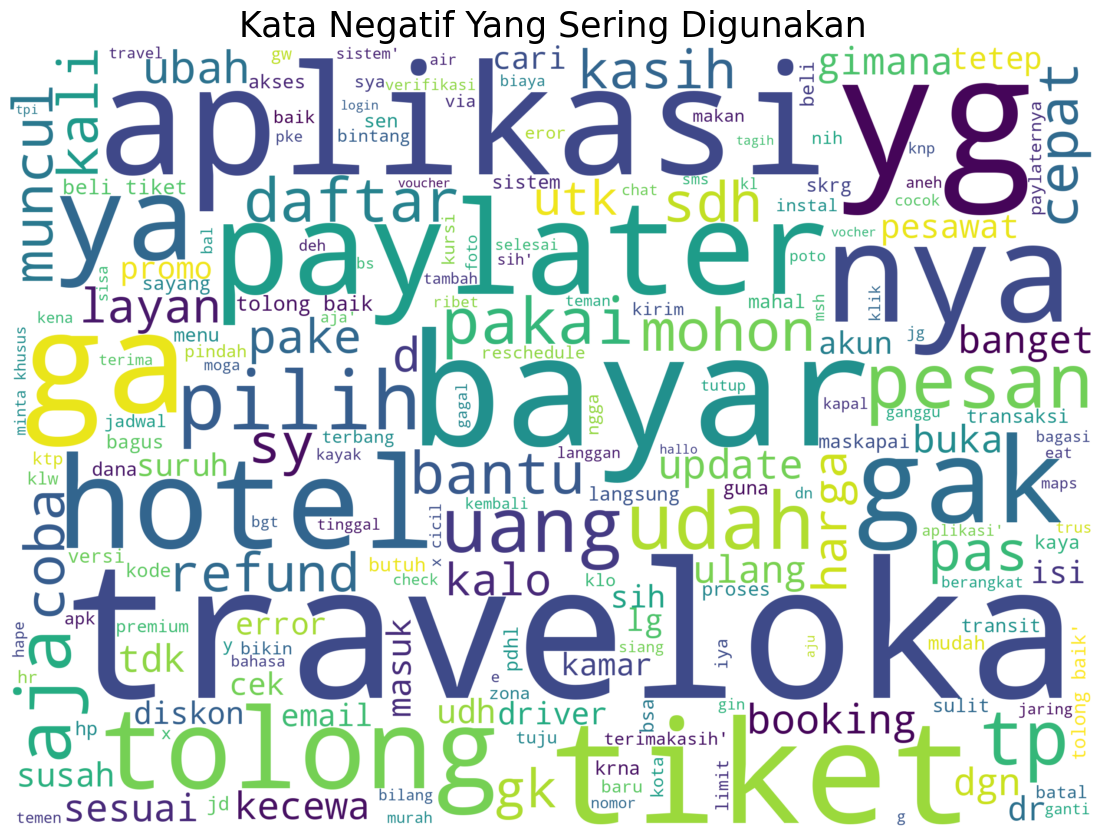

In [64]:
ens_learn_temp =ens_learn

ens_learn_temp['stemmed_review'].map(lambda x: re.sub('[,\.!?]', '', x))
ens_learn_temp['stemmed_review'].map(lambda x: x.lower())
neut_cloud=ens_learn_temp[ens_learn_temp['stemmed_review']=='neutral']

word_cloud = WordCloud(stopwords=STOPWORDS,
                      background_color='White',
                      width=2500,
                      height=1800
                     ).generate(filtered_neutral)
plt.figure(1,figsize=(14, 14))
plt.imshow(word_cloud,interpolation='bilinear')
plt.axis('off')
plt.title('Kata Negatif Yang Sering Digunakan', fontsize=25)
plt.show()

# **3. Data Preparation**

**3.1 Tokenizer & Data Encode**

Untuk memasukkan teks ke BERT, teks tersebut harus dipecah menjadi token, dan kemudian token ini harus dipetakan ke indeksnya dalam kosakata tokenizer.

In [65]:
!pip install transformers

In [66]:
from transformers import BertTokenizer

print("Loading IndoBERT Tokenizer")
tokenizer = BertTokenizer.from_pretrained('indolem/indobert-base-uncased', do_lower_case=True)

Loading IndoBERT Tokenizer


tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/234k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

In [67]:
sentences = ens_learn.stemmed_review.values
labels = ens_learn.label.values

In [69]:
print("Original: ", sentences[56])

print("Tokenized: ", tokenizer.tokenize (sentences[68]))

print("Token IDS: ", tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[68])))

Original:  kecewa traveloka dlm tangan tlpn trus cs nya habis pulsa
Tokenized:  ['setting', 'aplikasi', 'download', 'bahasa', 'indonesia', 'muncul', 'gagal', 'internet', 'putus', 'internet', 'pakai', 'wi', '##fi', 'mau', '##pa', '##un', 'paket', 'data']
Token IDS:  [17236, 5952, 12600, 2097, 1718, 2812, 3994, 4143, 7509, 4143, 7563, 7371, 2787, 2882, 2187, 1492, 6971, 3145]


In [68]:
print("Original: ", sentences[68])

print("Tokenized: ", tokenizer.tokenize (sentences[68]))

print("Token IDS: ", tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[68])))

Original:  setting aplikasi download bahasa indonesia muncul gagal internet putus internet pakai wifi maupaun paket data
Tokenized:  ['setting', 'aplikasi', 'download', 'bahasa', 'indonesia', 'muncul', 'gagal', 'internet', 'putus', 'internet', 'pakai', 'wi', '##fi', 'mau', '##pa', '##un', 'paket', 'data']
Token IDS:  [17236, 5952, 12600, 2097, 1718, 2812, 3994, 4143, 7509, 4143, 7563, 7371, 2787, 2882, 2187, 1492, 6971, 3145]


Fungsi `tokenizer.encode` menggabungkan beberapa langkah:
1. Membagi kalimat menjadi token.
2. Tambahkan token khusus `[CLS]` dan `[SEP]`.
3. Petakan token ke ID mereka.

In [70]:
input_ids = []

for sent in sentences:
    # Tokenisasi kalimat tanpa menambahkan token [CLS] dan [SEP]
    tokens = tokenizer.tokenize(sent)

    # Menambahkan token [CLS] di awal dan [SEP] di akhir
    tokens = ['[CLS]'] + tokens + ['[SEP]']

    # Mengonversi token menjadi ID menggunakan tokenizer
    encoded_sent = tokenizer.convert_tokens_to_ids(tokens)

    input_ids.append(encoded_sent)

# Menampilkan hasil untuk salah satu kalimat
print("Original: ", sentences[51])
print("Tokenized: ", tokenizer.tokenize (sentences[51]))
print("Token IDs: ", input_ids[51])


Original:  ribet klo ktpnya ga trus dibilangin cocok foto ktp wajah asli
Tokenized:  ['rib', '##et', 'klo', 'ktp', '##nya', 'ga', 'trus', 'dibilang', '##in', 'cocok', 'foto', 'ktp', 'wajah', 'asli']
Token IDs:  [3, 10550, 1548, 18475, 14634, 1519, 5311, 20700, 11107, 1488, 7031, 4724, 14634, 4570, 4332, 4]


In [71]:
# Check the longest sentence(token)

print("Max sentence length: ", max([len(sen) for sen in input_ids]))

Max sentence length:  124


In [72]:
from keras.preprocessing.sequence import pad_sequences

MAX_LEN =65

print("Padding/trucating all sentence to %d values" % MAX_LEN)
print('Padding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype='long', value=0, truncating='post', padding='post')

print("Done")

Padding/trucating all sentence to 65 values
Padding token: "[PAD]", ID: 0
Done


In [74]:
input_ids[56]

array([    3,  7369, 17248,  8825, 18425,  2741, 19349,  8868, 20700,
        9357,  2647,  5594, 18010,     4,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0])

In [75]:
attention_mask = []

for sent in input_ids:
  att_mask = [int(token_id > 0) for token_id in sent] # - Jika ID token adalah 0, maka itu adalah padding, set mask ke 0.
                                                      # - Jika ID token > 0, maka itu adalah token asli, set mask ke 1.

  attention_mask.append(att_mask)

In [76]:
# Misalkan batas adalah 10
batas = 10

for i in range(0, len(attention_mask[51]), batas):
    print(attention_mask[51][i:i+batas])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]


**3.2 Splitting**

Membagi data untuk menggunakan 70% untuk pelatihan dan 30% untuk testing.

In [77]:
from sklearn.model_selection import train_test_split

# Use 70% for training and 30% for testing.
train_input, test_input, train_labels, test_labels = train_test_split(input_ids,
                                                                      labels,
                                                                      random_state=2020,  # mengatur seed agar pembagian dataset dapat direproduksi
                                                                      test_size=0.3)
# Do the same for the masks.
train_mask, test_mask, _, _ = train_test_split(attention_mask,
                                               labels,
                                               random_state=2020,
                                               test_size=0.3)

In [78]:
import numpy as np
print("== Train ==")
print("Input: ", train_input.shape)
print("Label: ", train_labels.shape)
print("Mask: ", np.array(train_mask).shape)

print("\n== Test ==")
print("Input: ", test_input.shape)
print("Label: ", test_labels.shape)
print("Mask: ", np.array(test_mask).shape)

== Train ==
Input:  (1400, 65)
Label:  (1400,)
Mask:  (1400, 65)

== Test ==
Input:  (600, 65)
Label:  (600,)
Mask:  (600, 65)


**3.3 Creating data loaders**

In [79]:
import torch

if torch.cuda.is_available():
  device = torch.device('cuda')

  print('there are %d GPU(s) available.' % torch.cuda.device_count())

  print('we will use the GPU: ', torch.cuda.get_device_name(0))

else:
  print("No GPU available, using the CPU instead")
  device = torch.device("cpu")

there are 1 GPU(s) available.
we will use the GPU:  Tesla T4


Mengonversi ke Tipe Data PyTorch

In [80]:
train_input = torch.tensor(train_input)
train_labels = torch.tensor(train_labels)
train_mask = torch.tensor(train_mask)

test_input = torch.tensor(test_input)
test_labels = torch.tensor(test_labels)
test_mask = torch.tensor(test_mask)

In [81]:
# Membuat DataLoader dalam PyTorch

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 16

# Create the DataLoader for our training set.
train_data = TensorDataset(train_input, train_mask, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our testing set.
test_data = TensorDataset(test_input, test_mask, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

# **4. Modeling**

**4.1 Set-up BERT pretrained model**

Menggunakan Transformers library untuk menginisialisasi model BERT (Bidirectional Encoder Representations from Transformers) untuk tugas klasifikasi urutan (sequence classification) dalam bahasa Indonesia.

In [82]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

model = BertForSequenceClassification.from_pretrained(
    "indolem/indobert-base-uncased",
    num_labels = 3,
    output_attentions = False,
    output_hidden_states = False
)

model.cuda()

pytorch_model.bin:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31923, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

mencetak nama-nama dan dimensi dari bobot untuk:

1. Layer embedding.
2. Salah satu dari dua belas transformer.
3. Layer keluaran.

In [83]:
params = list(model.named_parameters())

print("The BERT model has {:} different named parameters.".format(len(params)))

print("==== Embedding Layer ====")
for p in params[0:5]:
  print("{:<60} {:>12}".format(p[0], str(tuple(p[1].size()))))

print("==== First Transformers ====")
for p in params[5:21]:
  print("{:<60} {:>12}".format(p[0], str(tuple(p[1].size()))))

print("==== Output Layer ====")
for p in params[-4:]:
  print("{:<60} {:>12}".format(p[0], str(tuple(p[1].size()))))

total_params = sum(p.numel() for p in model.parameters())
print("==== Total Parameters ====")
print(f'Total Parameters: {total_params}')

The BERT model has 201 different named parameters.
==== Embedding Layer ====
bert.embeddings.word_embeddings.weight                       (31923, 768)
bert.embeddings.position_embeddings.weight                     (512, 768)
bert.embeddings.token_type_embeddings.weight                     (2, 768)
bert.embeddings.LayerNorm.weight                                   (768,)
bert.embeddings.LayerNorm.bias                                     (768,)
==== First Transformers ====
bert.encoder.layer.0.attention.self.query.weight               (768, 768)
bert.encoder.layer.0.attention.self.query.bias                     (768,)
bert.encoder.layer.0.attention.self.key.weight                 (768, 768)
bert.encoder.layer.0.attention.self.key.bias                       (768,)
bert.encoder.layer.0.attention.self.value.weight               (768, 768)
bert.encoder.layer.0.attention.self.value.bias                     (768,)
bert.encoder.layer.0.attention.output.dense.weight             (768, 768)
bert.e

**4.2 Setting-up optimizer & schedular**

Dengan menggunakan optimizer ini, kita dapat mengoptimalkan parameter-model menggunakan metode backpropagation selama proses pelatihan (training).

In [84]:
optimizer = AdamW(
    model.parameters(),
    lr = 2e-5,
    eps = 1e-8
)

Dalam melakukan komputasi data, pada umumnya
menggunakan gradient descent untuk melakukan
proses penjumlahan dan turunan dengan tujuan
menemukan titik yang meminimumkan suatu fungsi
yang dapat diturunkan. Pada penelitian ini
menggunakan algoritma AdamW Optimizer. Seperti
Stochastic Gradient Descent, namun algoritma Adam
W memiliki keunggulan Root Mean Square
Propagation yang tidak dimiliki di Stochastic
Gradient Descent.

In [85]:
from transformers import get_linear_schedule_with_warmup

epochs = 10

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                             num_warmup_steps = 0,
                                             num_training_steps = total_steps)

**4.3 Training BERT**

In [86]:
import numpy as np

# Menghitung akurasi prediksi model terhadap label pada suatu tugas klasifikasi.
def flat_accuracy(preds, labels):
  pred_flat = np.argmax(preds, axis=1).flatten()
  labels_flat = labels.flatten()
  return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [87]:
import time
import datetime

# Mengelola waktu yang diukur dalam detik dan mengembalikan waktu yang diformat dengan representasi jam:menit:detik
def format_time(elapsed):
  elapsed_rounded = int(round(elapsed))
  return str(datetime.timedelta(seconds=elapsed_rounded))

In [88]:
import random

# --------------
# PERSIAPAN AWAL
# --------------

# Setting Seed:
# mengatur seed agar hasil eksperimen dapat diproduksi
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Inisialisasi Variabel:
# menyimpan nilai loss selama pelatihan.
loss_values = []


# --------------
# PELATIHAN MODEL
# --------------

# Loop Epoch:
# dilakukan loop sebanyak epochs (jumlah epoch yang ditentukan).
for epoch_i in range(0, epochs):

  # ===================================
  #              Training
  # ===================================

  print("======= Epoch {:} / {:} =======".format(epoch_i+1, epochs))
  print("Training...")

  t0 = time.time() # measure how long the training epoch takes.

  # Inisialisasi Total Loss:
  # deklasrasi nilai loss = 0 (direset ke 0 di awal setiap epoch).
  total_loss = 0

  # Set Model ke Mode Training:
  # mengaktifkan mode training pada model.
  model.train()

  # Loop Batches:
  # for each batch of training data (dilakukan loop untuk setiap batch di dalam train_dataloader).
  for step, batch in enumerate(train_dataloader):

    # Progress update/progress report every 1 batches:
    # diberikan informasi mengenai progress setiap batch.
    if step % 1 == 0 and not step == 0:
      elapsed = format_time(time.time() - t0)

      print("Batch {:>5,} of {:>5,}.     Elapsed: {:}".format(step, len(train_dataloader), elapsed))

    # Muat Data ke GPU/CPU:
    # token ids/data masukan, attention masks, dan label dari batch dimuat ke perangkat GPU.
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)

    model.zero_grad() # PyTorch
                      # dlm setiap batch, set gradien mjd set zero

    # Forward Pass:
    # model dimasukkan token ids, attention mask, dan label. Output berupa nilai loss.
    outputs = model(b_input_ids,
                    token_type_ids=None,  # diperlukan jika ingin melakukan klasifikasi menggunakan 2 sentences yg dianggap 1 data.
                    attention_mask=b_input_mask,
                    labels=b_labels)

    loss = outputs[0] # ambil nilai loss, utk mengambil nilai sebenarnya: menggunakan loss.item kemuddian lakukan backward.

    # Backward Pass:
    # gradien dihitung dan dilakukan backward pass.
    total_loss += loss.item()

    loss.backward()

    # PyTorch
    # Menerapkan normalisasi gradien untuk mencegah eksplosi gradien.
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # Optimasi dan Scheduler:
    # optimizer melakukan langkah optimisasi (mengupdate parameter model) dan scheduler dipindahkan.
    optimizer.step()

    scheduler.step()

  # Hitung Rata-rata Loss (total loss/jmh batch):
  # rata-rata loss dihitung untuk satu epoch.
  avg_train_loss = total_loss / len(train_dataloader)

  # Simpan Loss:
  # rata-rata loss disimpan di dalam loss_values.
  loss_values.append(avg_train_loss)

  print("   Average training loss: {0:.2f}".format(avg_train_loss))
  print("   Training epoch took: {:}".format(format_time(time.time() - t0)))


# ===================================
#             evaluation
# ===================================

# print("Running Evaluation...")

t0 = time.time()

# Set Model ke Mode Evaluasi:
# model.eval() mengubah model ke mode evaluasi.
model.eval()

train_loss, train_accuracy = 0, 0
nb_train_steps, nb_train_examples = 0, 0

# Loop Batches pada Data Uji:
# dilakukan loop untuk setiap batch di dalam train_dataloader.
for batch in train_dataloader:

  # Data disimpan dalam GPU
  # data uji dimuat ke perangkat GPU.
  batch = tuple(t.to(device) for t in batch)

  # Pisahkan batch lagi
  b_input_ids, b_input_mask, b_labels = batch

  # Forward Pass pada Data Uji:
  # dengan torch.no_grad(), model melakukan prediksi pada data uji.
  with torch.no_grad():
    outputs = model(b_input_ids,
                    token_type_ids=None,
                    attention_mask=b_input_mask)

  # Mengambil nilai output
  # Labelnya dikembalikan
  logits = outputs[0]
  logits = logits.detach().cpu().numpy()    # Disimpan di CPU, karena akan ada proses matematis sederhana
  label_ids = b_labels.to('cpu').numpy()

  # Hitung Akurasi pada Data Uji (jmh data yg sesuai/seluruh data):
  # akurasi dihitung dengan fungsi flat_accuracy().
  tmp_train_accuracy = flat_accuracy(logits, label_ids)

  train_accuracy += tmp_train_accuracy

  nb_train_steps += 1

# Tampilkan Hasil Pengujian:
# tampilkan akurasi dan waktu pengujian.
print("   Accuracy: {0:.2f}".format(train_accuracy/nb_train_steps))
print("   Testing took: {:}".format(format_time(time.time() - t0)))


print("Training complete!")

======= Epoch 1 / 10 =======
Training...
Batch     1 of    88.     Elapsed: 0:00:03
Batch     2 of    88.     Elapsed: 0:00:03
Batch     3 of    88.     Elapsed: 0:00:04
Batch     4 of    88.     Elapsed: 0:00:04
Batch     5 of    88.     Elapsed: 0:00:04
Batch     6 of    88.     Elapsed: 0:00:04
Batch     7 of    88.     Elapsed: 0:00:04
Batch     8 of    88.     Elapsed: 0:00:05
Batch     9 of    88.     Elapsed: 0:00:05
Batch    10 of    88.     Elapsed: 0:00:05
Batch    11 of    88.     Elapsed: 0:00:05
Batch    12 of    88.     Elapsed: 0:00:05
Batch    13 of    88.     Elapsed: 0:00:06
Batch    14 of    88.     Elapsed: 0:00:06
Batch    15 of    88.     Elapsed: 0:00:06
Batch    16 of    88.     Elapsed: 0:00:06
Batch    17 of    88.     Elapsed: 0:00:06
Batch    18 of    88.     Elapsed: 0:00:07
Batch    19 of    88.     Elapsed: 0:00:07
Batch    20 of    88.     Elapsed: 0:00:07
Batch    21 of    88.     Elapsed: 0:00:07
Batch    22 of    88.     Elapsed: 0:00:07
Batch    23 o

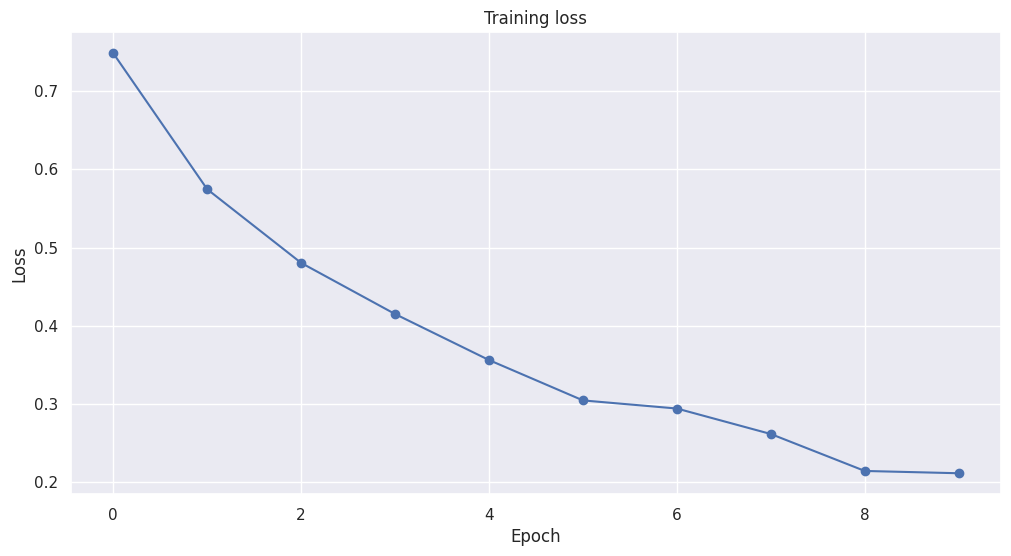

In [89]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='darkgrid')
sns.set(font_scale=1)
plt.rcParams["figure.figsize"] = (12, 6)

plt.plot(loss_values, 'b-o')

plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

# **5. Predict & Evaluate**

In [90]:
print("Predicting labels for {:,} test sentences".format(len(test_input)))

model.eval()

prediction, true_labels = [], []

for batch in test_dataloader:
  batch = tuple(t.to(device) for t in batch)

  b_input_ids, b_input_mask, b_labels = batch

  with torch.no_grad():
    outputs = model(b_input_ids,
                    token_type_ids=None,
                    attention_mask=b_input_mask)

  logits = outputs[0]

  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  prediction.append(logits)
  true_labels.append(label_ids)

print(" DONE.")

Predicting labels for 600 test sentences
 DONE.


In [91]:
flat_prediction = [item for sublist in prediction for item in sublist]
flat_prediction = np.argmax(flat_prediction, axis=1).flatten()

flat_true_labels = [item for sublist in true_labels for item in sublist]

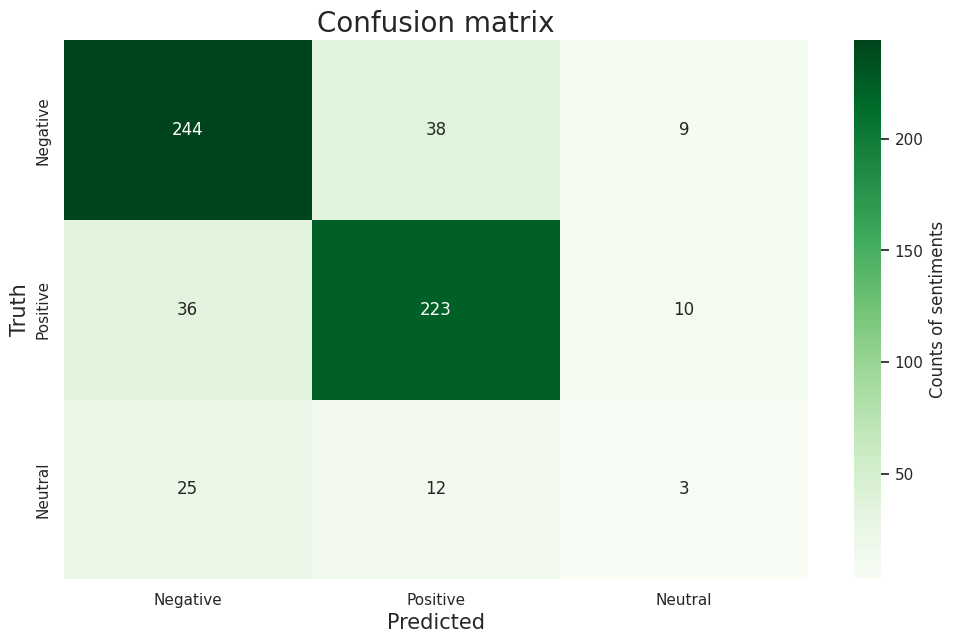

In [92]:
# Menghitung confusion matrixflat_true_labels, flat_prediction
cm_hasil = confusion_matrix(flat_true_labels, flat_prediction)

# Plot confusion matrix
plt.figure(figsize=(12, 7))
sentiment_classes = ['Negative', 'Positive', 'Neutral']
sb.heatmap(cm_hasil, cmap=plt.cm.Greens, annot=True, cbar_kws={'label': 'Counts of sentiments'}, fmt='d',
            xticklabels=sentiment_classes,
            yticklabels=sentiment_classes)
plt.xlabel('Predicted', fontsize=15)
plt.ylabel('Truth', fontsize=15)
plt.title('Confusion matrix', fontsize=20)
plt.show()

In [93]:
from sklearn.metrics import confusion_matrix

print(classification_report(flat_true_labels, flat_prediction))

              precision    recall  f1-score   support

           0       0.80      0.84      0.82       291
           1       0.82      0.83      0.82       269
           2       0.14      0.07      0.10        40

    accuracy                           0.78       600
   macro avg       0.58      0.58      0.58       600
weighted avg       0.76      0.78      0.77       600



In [94]:
from sklearn.metrics import matthews_corrcoef

mcc = matthews_corrcoef(flat_true_labels, flat_prediction)

print("MCC: %.3f" %mcc)

MCC: 0.605


In [95]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(flat_true_labels, flat_prediction)

print("ACC: %.3f" %acc)

ACC: 0.783
